# Isolating Bioelectrical Signal by Leak Subtraction

### *Personal Note*

*I like this analysis because it is tidy and neat. From a general data science perspective it demonstates signal processing, parameter optimization, model fitting, and some biophysics. The data was part of a more extensive projected were I explored the application of stem cell derived cardiomyocytes in arrhythmia detection. I hope you find it interesting.*

## 1. Introduction

Electrial signals play a critical role in the normal physiology of biological cells. Consequently, it is of interest to understand and develop models of cellular electrophysiology for biotechnical and theraputic reasons. The development of electrophysiolgical models and experimental techniques to measure bioelectrical activity has an incredibly rich history. I found the field interesting because it is an area of biology that can be studied from a from a bottom-up approach.

The technical setup I used to acquire the data used here is called a voltage patch clamp (VC). During a VC experiment an electrode is placed beneath the cellular membrane to control the voltage across the membrane. A time-series of voltages are then input across the cellular membrane and the total current is recorded as output.

This particular data is my out-of-sample data that I need to clean up to evaluate the model's predictive performance. In the last section I will qualitatively compare the cleaned signal to a trained model.

The time-series data is defined:

***Input***: Voltage in $millivolt\text{ }(mV) $<br>
***Output***: Current density in $picoampere * picofarad^{-1}\text{ }(pA/pF)$

Let's take a look at the data.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
c5_vc = pd.read_csv('./c5_vc_tImV.csv', delimiter=' ')
c5_vc.head()

,t_ms,i_pApF,mV
0,0.0,-1.857508,-80.000000
1,0.1,-1.892333,-79.955966
2,0.2,-1.827658,-79.911932
3,0.3,-1.862483,-79.867898
4,0.4,-1.912233,-79.823864


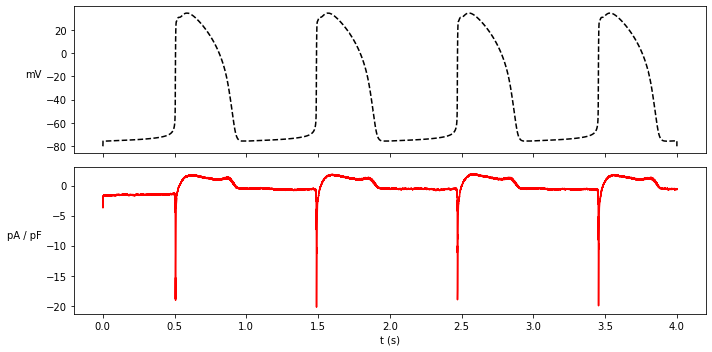

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,5))
# Draw voltage trace
ax1.plot(c5_vc.t_ms/1000, c5_vc.mV, color='black', linestyle='--')
ax1.set_ylabel('mV', color='black')
ax1.yaxis.label.set(rotation='horizontal', ha='right');

# Draw current trace
ax2.plot(c5_vc.t_ms/1000, c5_vc.i_pApF, color='red')
ax2.set_xlabel('t (s)', color='black')
ax2.set_ylabel('pA / pF')
ax2.yaxis.label.set(rotation='horizontal', ha='right');

fig.tight_layout()
plt.show()

#### Notes and observations about the data

1. The command-voltage (input) waveform was choosen before the experiment. The shape mimics 4 cardiomyocyte action potentials (APs).

2. The temporal resolution is 0.1 ms.

3. The signal I want to isolate is nonlinear over the votlage trace and is dependent on both time and voltage.

4. There is high frequency (hf) noise component that is recorded during the experiment. The magnitude of the hf-noise is much smaller than the signal. I calibrated the equipment and try to denoise the instruments as much as possible. I also checked to ensure the hf-noise in normally distributed at several voltages prior to the experiment.

## 2. Linear Leak Current

The raw output contains a nonlinear current that is from the cell (the part to isolate) and noise from the instrument. There is an additional component in the output that arises during a voltage clamp experiment because the electrode cannot be perfectly placed on the interior of the cell membrane. This component is referred to as *leak current* and follows Ohm's law:
$$
    V = IR
$$
where V is the voltage, I is current and R is resistance. In voltage clamp data, I is the dependent variable and V is the independent variable. So it is more useful to rewrite the equation:
$$
    I = GV
$$
where G is the conductance and is R^-1 (in nanosiemen, nS).

A leak current by definition reverses direction at the origin (V=0, I=0). Other biological currents conduct specific ions (K+, Cl-, Na+, etc.) and do not have reversal potentials at the origin. These offsets are generated by the biological cell's electrical proteins that pump ions to different sides of the membrane creating a chemical potential.

### Fitting the leak conductance: *G*

The data and the model equation for the leak component have been defined. The parameter to optimize is the leak conductance *G*. 

I will minimize the root mean squared error (RMSE) manually at first and then again using a *scipy*'s *minimize_scalar* function.

*There is an interpretation of G that can indicate the overall quality of the data, but requires more experimental context and parameters. Since the objective here is to isolate the biological current, the optimized value of G will be the product of multiple parameters that fits the leak current best. This differs from the leak_subtraction_BATCH.py version.*

In [5]:
# Define the range of G that covers several orders of magnitude
g_leak = np.logspace(start=-5, stop=-1, num=50, endpoint=True)  # I used some trial and error

# Define a function to calculate RMSE
def calc_rmse(i_pApF, i_leak_pApF):
    n = float(len(i_pApF)) # number of points
    rmse = (sum((i_pApF - i_leak_pApF)**2) / n)**0.5
    return(rmse)

# Loop through and calculate the RMSE for the conductance range
rmse_leak = []
for g in g_leak:
    i_leak = (g * c5_vc.mV)
    rmse_leak.append(calc_rmse(c5_vc.i_pApF, i_leak))

G_leak Estimate: 0.010481131341546853


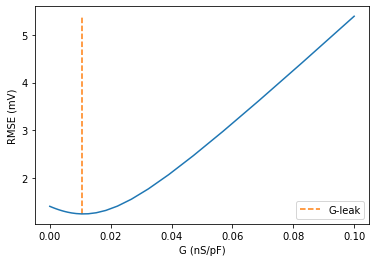

In [6]:
# Find the value of G that minimizes RMSE
g_leak_crude = g_leak[rmse_leak.index(min(rmse_leak))]
print(f"G_leak Estimate: {g_leak_crude}")

# Plot RMSE v G and G-crude
plt.plot(g_leak, rmse_leak)
plt.xlabel('G (nS/pF)')
plt.ylabel('RMSE (mV)')
plt.vlines(x = g_leak_crude, ymin = min(rmse_leak), ymax = max(rmse_leak),
           colors = 'tab:orange',
           linestyle='--',
           label = 'G-leak')
plt.legend(loc=4)
plt.show()

*Not bad! The value of G has a clear minimum.*

### Fitting with *minimize_scalar*

In [7]:
from scipy.optimize import minimize_scalar

In [8]:
# minimize_scalar needs a scalar function as an argument
def objective_min_rmse(g):
    i_leak = (g * c5_vc.mV)
    return(calc_rmse(c5_vc.i_pApF, i_leak))

In [9]:
res = minimize_scalar(objective_min_rmse)
res

     fun: 1.2442661461134306
    nfev: 18
     nit: 14
 success: True
       x: 0.011047083109320168

*The solution from minimize_scalar is more precise, so is preferred. Occasionally, it is helpful to me to solve the problem in multiple ways for sanity.*

### Visualization of the fitted leak current

In the previous section we calculated the leak conductance. Next, I'll visiualize the leak component and subtract it from the raw current. 

In [10]:
# Calculate the leak current with the optimized conductance
i_leak_fitted = res.x * c5_vc.mV

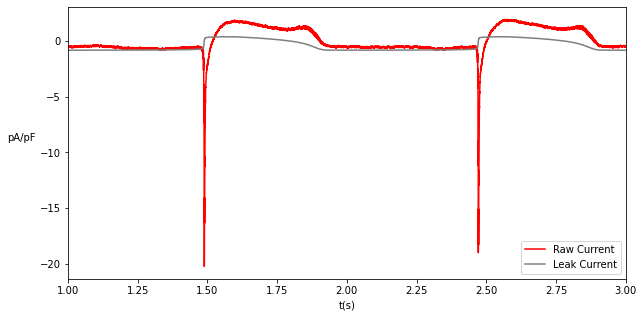

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
# Plot the raw current with the leak component with a focused view from 1 to 3 seconds
ax.plot(c5_vc.t_ms/1000, c5_vc.i_pApF, color='red', label='Raw Current')
ax.plot(c5_vc.t_ms/1000, i_leak_fitted, label='Leak Current', color='tab:gray')
plt.xlim(1.0, 3.0)
ax.set_xlabel('t(s)', color='black')
ax.set_ylabel('pA/pF', color='black')
ax.yaxis.label.set(rotation='horizontal', ha='right')
plt.legend(loc=4)
plt.show()


*Physiological Context*

*The different phases of the voltage waveform (dotted grey in the first figure) highlight the biological signal. If you recall having your blood pressure (BP) taken there are two pressure readings that correspond to single-cell phases observed here, the systolic (higher number ~120 mmHg) and the diastolic (lower number ~80 mmHg). The systolic phase corresponds to when the heart has contracted pumping blood through the body (hence the higher pressure reading). In this zoomed in view there there are two single-cell contractions starting just before 1.5 and 2.5 seconds that end approximately 0.45 seconds later. The diastolic phase follows the systolic phase when the heart muscle is relaxing the filling with blood. The cardiac cell here relaxes and the voltage and current remains nearly constant during diastolic phase.*

**Notes and observations about the fitted leak current**

1. There is a negative current downstroke just before 1.5 and 2.5 seconds. This contrasts the leak current which is increasing.
2. The leak contributes to the postive current magnitude following the downstroke.
3. Raw current is approximately the same magnitude as the leak current during the diastolic phase. For instance, the current between ~1.85 and 2.45 s.

## 3. Comparison of the leak-subtracted current to the predicted current from a trained model  

In this last section, I want to calculate the error between the leak subtracted current and the *total current* predicted by a trained model. The biological current presented thus far is the summation of currents from specific proteins that facilitate ions passing between the inside and outside the cell. In the voltage-clamp experiment described above, there is no way to easily deconvolute the *total current* to find the quantities of the specific currents. In cardiomyocyte models the known currents (characterized by prior experiments) are specified, and training a model to single-cell dataset involves optimizing the quantities of each current.

Let's take a look at the model data.

In [12]:
model = pd.read_csv('model_3_kernik_vcp.txt', delimiter=' ')
model.head()

,I_total,I_K1,I_To,I_Kr,I_Ks,I_CaL,I_NaK,I_Na,I_NaCa,I_pCa,I_F,I_bNa,I_bCa,I_CaT,t,vcmd
0,-0.290568,0.052684,9.196453e-21,0.000374,0.000405,-0.016171,0.091149,-0.001693,-0.025176,0.007631,-0.382574,-0.001318,-0.013278,-0.002603,0.0,-80.000000
1,-0.290078,0.052882,9.248325e-21,0.000376,0.000407,-0.016180,0.091184,-0.001708,-0.025111,0.007631,-0.382354,-0.001318,-0.013277,-0.002612,0.1,-79.955966
2,-0.289588,0.053079,9.300197e-21,0.000378,0.000409,-0.016188,0.091219,-0.001722,-0.025047,0.007631,-0.382133,-0.001317,-0.013275,-0.002622,0.2,-79.911932
3,-0.289098,0.053277,9.352070e-21,0.000380,0.000411,-0.016197,0.091253,-0.001737,-0.024982,0.007631,-0.381913,-0.001317,-0.013274,-0.002631,0.3,-79.867898
4,-0.288608,0.053474,9.403942e-21,0.000382,0.000413,-0.016206,0.091288,-0.001751,-0.024918,0.007631,-0.381692,-0.001317,-0.013272,-0.002641,0.4,-79.823864


The current needed to calculate the error is the *I_total.* I have cleaned the model data prior to loading it, so it should be ready to compare, but first we need to subtract the leak current. The leak current is an experimental artifact, so is not modeled.

In [15]:
# Subtract the leak current from the raw current
i_leak_subtracted = c5_vc.i_pApF - i_leak_fitted

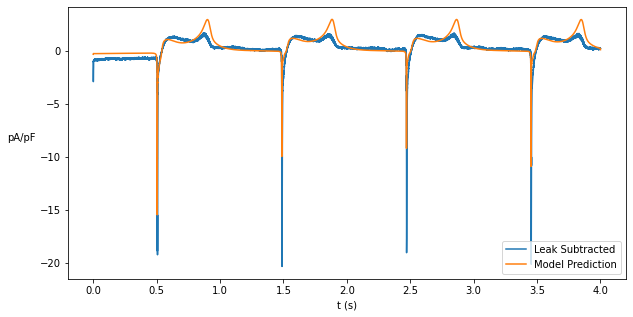

In [16]:
# Plot I_total and i_leak_subtracted
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(c5_vc.t_ms/1000, i_leak_subtracted, label='Leak Subtracted', color='tab:blue')
ax.plot(model.t/1000, model.I_total, label='Model Prediction', color='tab:orange')
ax.set_xlabel('t (s)', color='black')
ax.set_ylabel('pA/pF', color='black')
ax.yaxis.label.set(rotation='horizontal', ha='right')
plt.legend(loc=4)
plt.show()

We could use previously defined function *calc_rmse(i_pApF, i_leak_pApF)* to get the RMSE, but because the model current is a prediction it would be useful to know where the deviations occur. 

In [17]:
# Check the length of the current traces
print(f'Experiment: {len(i_leak_subtracted)}, Model: {len(model.I_total)}')

Experiment: 40001, Model: 40001


In [18]:
# Calculate the square error for plotting
sqr_err = (i_leak_subtracted - model.I_total)**2

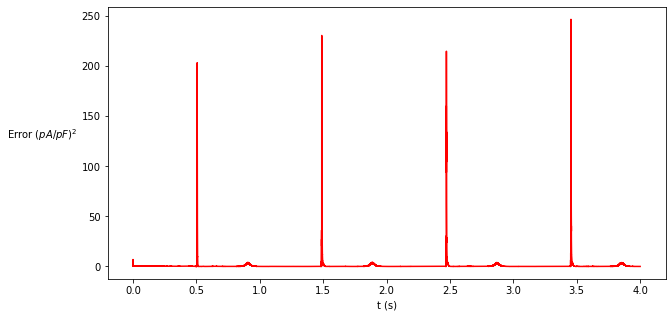

In [20]:
# Plot the error
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(c5_vc.t_ms/1000, sqr_err, color='red')
ax.set_xlabel('t (s)', color='black')
ax.set_ylabel('Error $(pA / pF)^2$')
ax.yaxis.label.set(rotation='horizontal', ha='right');
plt.show()

### Findings and takeaways

1. There are two areas in the current trace where we can visually identify a deviation between the model and the experiment. The negative current spike at the beginning of the action potential which is approximately at 0.5, 1.5, 2.5, 3.5 s, and the repolarization ~0.430 s following. The specific currents that are active during these phases will indicate which quanties are off. Qualitatively the model does well, but quantitative predictions need to be approached with caution. These models are often used to predict drug safety for potential theraputics before clinical trials. Drug interactions effects are quite complex, so models are valuable for their interpretability. 
2. The linear leak current can be separated from the nonlinear bioelectric current and is critical for model comparison.